# Preparation

Importing necessary modules

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from math import ceil, fabs
from numpy import random
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Advanced Line Finding

## Camera Calibration and Distortion Correction

In [2]:
nx = 9
ny = 5
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)


def findChessboardCorners(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    return ret, corners


def drawChessboardCorners(ret, corners, img):
    # If chessboard corners found
    if ret == True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


def getObjImgPointsAndShape(fname_pattern):
    objpoints = []
    imgpoints = []
    shape = None

    # Getting the image files
    images = glob.glob(fname_pattern)

    for fname in images:
        img = mpimg.imread(fname)

        if shape is None:
            shape = img.shape[1::-1]

        ret, corners = findChessboardCorners(img)

        # If found, adding image points and object points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    return objpoints, imgpoints, shape


class Calibration:
    def __init__(self, ret, mtx, dist, rvecs, tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs      


def calibrateCamera(fname_pattern):
    objpoints, imgpoints, shape = getObjImgPointsAndShape(fname_pattern);
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return Calibration(ret, mtx, dist, rvecs, tvecs)


def undistortImage(img, calibration):
    return cv2.undistort(img, calibration.mtx, calibration.dist, None, calibration.mtx)


# Calibrating camera
calibration = calibrateCamera('camera_cal/calibration*.jpg')

## Color/Gradient Threshold

In [3]:
def getThresholdedBinaryImage(img, s_thresh=(170, 255), sx_thresh=(14, 50)):
    img = np.copy(img)

    # Convert to HLS color space and separate the L and S channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    if sx_thresh is not None:
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    if s_thresh is not None: 
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combinning pixels passing any of both thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary * 255

## Perspective transform

In [4]:
src = np.float32([[520, 500], [765, 500], [200, 720], [1100, 720]])
dst = np.float32([[320, 500], [980, 500], [320, 720], [980, 720]])


class PerspectiveTransform:
    def __init__(self, perspectiveMatrix, inversePerspectiveMatrix):
        self.perspectiveMatrix = perspectiveMatrix
        self.inversePerspectiveMatrix = inversePerspectiveMatrix    


def getPerspectiveTransform(src, dst):
    # Computing the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Computing the inverse perspective transform
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Retuning perspective transform object
    return PerspectiveTransform(M, M_inv)


def getWarpedImage(img, perspectiveTransform):
    return cv2.warpPerspective(img, perspectiveTransform.perspectiveMatrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


def getUnwarpedImage(img, perspectiveTransform):
    return cv2.warpPerspective(img, perspectiveTransform.inversePerspectiveMatrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


# Calculating the perspective transform
perspectiveTransform = getPerspectiveTransform(src, dst)


def getBirdsEyeView(undist):
    binary = getThresholdedBinaryImage(undist)
    warped_binary = getWarpedImage(binary, perspectiveTransform)
    return warped_binary

## Lane Lines Detection

In [5]:
# window settings
window_width  = 80
window_height = 80  # Breaking image into 9 vertical layers since image height is 720
margin        = window_width/2 # How much to slide left and right for searching


def applyLaneLinePolynomial(y, fit):
    return fit[0] * y**2 + fit[1] * y + fit[2]


def findWindowCentroids(img, l_fit=None, r_fit=None):
    # To store the (left,right) window centroid positions per level
    window_centroids = []
    # Creating our window template that we will use for convolutions
    window = np.ones(window_width)

    max_x = img.shape[1]
    max_y = img.shape[0]

    # If not given polynomial, finding the two starting positions for the left and right lane lines
    # By using np.sum getting the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Summing quarter bottom of image to get slice, could use a different ratio
    # If polynomial is given starting from the calculated init point on the bottom

    if l_fit is None:
        l_sum    = np.sum(img[int(3 * max_y/4):, :int(max_x/2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    else:
        l_center = applyLaneLinePolynomial(max_y, l_fit)

    if r_fit is None:
        r_sum    = np.sum(img[int(3 * max_y/4):, int(max_x/2):], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(max_x/2)
    else:
        r_center = applyLaneLinePolynomial(max_y, r_fit)

    # Adding the found centroids for the first layer
    window_centroids.append((l_center, r_center))

    # Going through each layer looking for max pixel locations
    for level in range(1, (int)(max_y / window_height)):
        # Convolving the window into the vertical slice of the image
        img_layer = np.sum(img[int(max_y - (level+1) * window_height):
                               int(max_y - level * window_height), :],
                           axis=0)
        conv_signal = np.convolve(window, img_layer)
        # Finding the best left centroid by using past left center as a reference
        # Using window_width/2 as offset because convolution signal reference is at right side of window,
        # not center of window
        offset = window_width/2
        l_min_index = int(max(l_center + offset - margin, 0))
        l_max_index = int(min(l_center + offset + margin, max_x))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        # Finding the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center + offset - margin, 0))
        r_max_index = int(min(r_center + offset + margin, img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Adding what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids


def windowMask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level+1) * height) : int(img_ref.shape[0] - level * height),
           max(0, int(center - width/2)) : min(int(center + width/2), img_ref.shape[1])] = 1
    return output


def identifyPointsOfLaneLinesInImage(window_centroids, img):
    l_points_img = np.zeros_like(img)
    r_points_img = np.zeros_like(img)

    # If any window centers where found
    if len(window_centroids) > 0:

        # Going through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # windowMask is a function to draw window areas
            l_mask = windowMask(window_width, window_height, img, window_centroids[level][0], level)
            r_mask = windowMask(window_width, window_height, img, window_centroids[level][1], level)
            # Adding graphic points from window mask here to total pixels found 
            l_points_img[(img >= 128) & (l_mask == 1)] = 255
            r_points_img[(img >= 128) & (r_mask == 1)] = 255

    return l_points_img, r_points_img


def getPointsOfLaneLine(points_img):
    return points_img.nonzero()


def getPointsOfLaneLines(l_points_img, r_points_img):
    return getPointsOfLaneLine(l_points_img), getPointsOfLaneLine(r_points_img)


def fitLaneLinePolynomial(points):
    return np.polyfit(points[0], points[1], 2)


def fitLaneLinesPolynomials(l_points, r_points):
    left_fit  = np.polyfit(l_points[0], l_points[1], 2)
    right_fit = np.polyfit(r_points[0], r_points[1], 2)
    return left_fit, right_fit


def drawWindowCentroids(window_centroids, img):
    # If any window centers where found
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Going through each level and draw the windows
        for level in range(0, len(window_centroids)):
            # windowMask is a function to draw window areas
            l_mask = windowMask(window_width, window_height, img, window_centroids[level][0], level)
            r_mask = windowMask(window_width, window_height, img, window_centroids[level][1], level)
            # Adding graphic points from window mask here to total pixels found 
            l_points[l_mask == 1] = 255
            r_points[r_mask == 1] = 255

        # Drawing the results
        # adding both left and right window pixels together
        template = np.array(r_points + l_points, np.uint8)
        # creating a zero color channel
        zero_channel = np.zeros_like(template)
        # making window pixels cyan
        template = np.array(cv2.merge((zero_channel, template, template)), np.uint8)
        # making the original road pixels 3 color channels
        warpage= np.dstack((img, img, img))
        # overlaying the orignal road image with window results
        return cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

    # If no window centers found, just displaying orginal road image
    else:
        return np.array(cv2.merge((img, img, img)),np.uint8)


def drawIdentifiedPointsOfLaneLines(l_points_img, r_points_img, img):
    output = img.copy()
    # Drawing left lane line's points in red
    output[l_points_img > 0] = [255, 0, 0]
    # Drawing right lane line's points in blue
    output[r_points_img > 0] = [0, 0, 255]
    return output


def drawLaneLinesPolynomials(l_fit, r_fit, ref_img, plot, l_color = 'yellow', r_color = 'yellow', linewidth=1.0): 
    y = np.linspace(0, ref_img.shape[0] - 1, ref_img.shape[0])
    l_x = applyLaneLinePolynomial(y, l_fit)
    r_x = applyLaneLinePolynomial(y, r_fit)
    # Drawing the predicted lane points from polynomials in yellow
    plot.plot(l_x, y, color=l_color, linewidth=linewidth)
    plot.plot(r_x, y, color=r_color, linewidth=linewidth)



# Defining conversions in x and y from pixels space to meters
# Meters per pixel in y dimension
LANE_WIDTH_METERS = 3.7
ym_per_pix = 600/720
xm_per_pix = LANE_WIDTH_METERS/660


def calculateCurvatureOfLaneLine(fit, ref_img):
    max_y = ref_img.shape[0]
    return ((1 + (2 * fit[0] * max_y * ym_per_pix + fit[1])**2)**1.5) / np.absolute(2 * fit[0])


def calculateCurvatureOfLaneLines(l_fit, r_fit, ref_img):
    left_curve_rad = calculateCurvatureOfLaneLine(l_fit, ref_img)
    right_curve_rad = calculateCurvatureOfLaneLine(r_fit, ref_img)
    return left_curve_rad, right_curve_rad


def calculateLaneLineBasePosition(fit, ref_img):
    max_y = ref_img.shape[0]
    mid_x = ref_img.shape[1] / 2
    return (applyLaneLinePolynomial(max_y, fit) - mid_x) * xm_per_pix


def calculateLaneLinesBasePositions(l_fit, r_fit, ref_img):
    return calculateLaneLineBasePosition(l_fit, ref_img), calculateLaneLineBasePosition(r_fit, ref_img)


def calculateDistanceToLaneLines(l_fit, r_fit, ref_img):
    return -calculateLaneLineBasePosition(l_fit, ref_img), calculateLaneLineBasePosition(r_fit, ref_img)



# Defining a class to receive the characteristics of each line detection
class Line():
    def __init__(self, fit, allx, ally, image):
        self.current_fit = fit
        self.allx = allx
        self.ally = ally
        self.image = image
        self.radius_of_curvature = calculateCurvatureOfLaneLine(fit, image)
        self.base_position = calculateLaneLineBasePosition(fit, image)


BUFFER_SIZE = 50

# A subclass of line to mantain the previosly identified lines and
# use them to implemet fault tolerance mechanisms
class BufferedLine(Line):
    def __init__(self, detected, line, prev_buffered_line=None):
        Line.__init__(self, line.current_fit, line.allx, line.ally, line.image)

        # If the line was successfully detected, i.e. passed the sanity test
        self.detected = detected

        # Getting the previously detected lines
        if prev_buffered_line is None:
            self.recent_fits = deque()
        else:
            self.recent_fits = prev_buffered_line.recent_fits

        # Getting last line out of the buffer
        if line is not None and detected:
            # If the current line was successfully detected is added to the buffer
            self.recent_fits.append(line.current_fit)
            while len(self.recent_fits) > BUFFER_SIZE:
                self.recent_fits.popleft()
        else:
            if len(self.recent_fits) > 0:
                self.recent_fits.popleft()

        # Calculating the best fit, to do a prediction in case the line was not successfully detected
        # and smothing the results
        if len(self.recent_fits) > 0:
            fits = np.array(self.recent_fits)
            if (self.detected):
                # Using a rate to give the most recently detected line more weight in the result
                self.avg_fit = (0.25 * line.current_fit + 
                                0.75 * np.array([np.mean(fits[:,0]), np.mean(fits[:,1]), np.mean(fits[:,2])]))
            else:
                self.avg_fit = [np.mean(fits[:,0]), np.mean(fits[:,1]), np.mean(fits[:,2])]
        else:
            self.avg_fit = line.current_fit

    def avg_radius_of_curvature(self):
        return calculateCurvatureOfLaneLine(self.avg_fit, self.image)

    def avg_base_position(self):
        return calculateLaneLineBasePosition(self.avg_fit, self.image)


def getDistanceBetweenLaneLinesInMeters(l_line, r_line, ref_img):
    max_y = ref_img.shape[0]
    l_x = applyLaneLinePolynomial(max_y, l_line.current_fit)
    r_x = applyLaneLinePolynomial(max_y, r_line.current_fit)
    return np.abs(l_x - r_x) * xm_per_pix


def verifyParallelism(l_line, r_line, a_diff_threshold=0.01, b_diff_threshold=0.35):
    if np.abs(l_line.current_fit[0] - r_line.current_fit[0]) > a_diff_threshold:
        return False
    if np.abs(l_line.current_fit[1] - r_line.current_fit[1]) > b_diff_threshold:
        return False
    return True


def verifyContinuityOfLaneLine(line, prev_line,
                               a_diff_threshold=0.01, b_diff_threshold=0.35, c_diff_threshold=200):
    if np.abs(line.current_fit[2] - prev_line.avg_fit[2]) > c_diff_threshold:
        return False
    if np.abs(line.current_fit[1] - prev_line.avg_fit[1]) > b_diff_threshold:
        return False
    if np.abs(line.current_fit[0] - prev_line.avg_fit[0]) > a_diff_threshold:
        return False
    return True


def sanityCheck(l_line, r_line, prev_l_line, prev_r_line, ref_image):
    if l_line is None or r_line is None:
        return False
    if not verifyParallelism(l_line, r_line):
        return False
    if np.abs(getDistanceBetweenLaneLinesInMeters(l_line, r_line, ref_image) - LANE_WIDTH_METERS) > 0.4:
        return False
    if prev_l_line is not None and not verifyContinuityOfLaneLine(l_line, prev_l_line):
        return False
    if prev_r_line is not None and not verifyContinuityOfLaneLine(r_line, prev_r_line):
        return False
    return True


def detectLaneLines(image, prev_l_line=None, prev_r_line=None,
                    window_width = window_width, window_height = window_height, margin = margin):

    # Getting the searching windows' centroids
    window_centroids = findWindowCentroids(image,
                                           l_fit=(prev_l_line.avg_fit if prev_l_line is not None else None),
                                           r_fit=(prev_r_line.avg_fit if prev_r_line is not None else None))
    # Getting the identified points for left and right lanes
    l_points_img, r_points_img = identifyPointsOfLaneLinesInImage(window_centroids, image)
    # Getting the collection of points for the left and right lane lines
    l_points, r_points = getPointsOfLaneLines(l_points_img, r_points_img)
    # Getting the polynomials for the left and right lane lines
    l_fit, r_fit = fitLaneLinesPolynomials(l_points, r_points)

    # Creating the left and right lane lines
    l_line = Line(l_fit, l_points[1], l_points[0], image)
    r_line = Line(r_fit, r_points[1], r_points[0], image)

    # Performing sanity check to the identified lines
    detected = sanityCheck(l_line, r_line, prev_l_line, prev_r_line, image)

    l_line = BufferedLine(detected, l_line, prev_l_line)
    r_line = BufferedLine(detected, r_line, prev_r_line)

    return l_line, r_line



def drawFoundLaneOverImage(undist, l_line, r_line):
    # Creating some sample points fro polynomials to draw the lanes
    y = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    l_x = applyLaneLinePolynomial(y, l_line.avg_fit) if l_line is not None else None
    r_x = applyLaneLinePolynomial(y, r_line.avg_fit) if r_line is not None else None

    # Getting radius of curvature and distance to center
    curv_rad = None
    dist_to_center = None
    if l_line is not None and r_line is not None:
        curv_rad = (l_line.avg_radius_of_curvature() + r_line.avg_radius_of_curvature()) / 2.0
        dist_to_center = (r_line.avg_base_position() + l_line.avg_base_position()) / 2.0
    elif l_line is not None:
        curv_rad = l_line.avg_radius_of_curvature()
    elif r_line is not None:
        curv_rad = r_line.avg_radius_of_curvature()

    # Create an images to draw the lane and lines on
    warp_zero = np.zeros((undist.shape[0], undist.shape[1])).astype(np.uint8)
    lane_img = np.dstack((warp_zero, warp_zero, warp_zero))
    l_line_img = np.dstack((warp_zero, warp_zero, warp_zero))
    r_line_img = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_x, y]))]) if l_x is not None else None
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x, y])))]) if r_x is not None else None
    pts = np.hstack((pts_left, pts_right)) if pts_left is not None and pts_right is not None else None

    # Draw the lane onto the warped blank image
    if pts is not None:
        cv2.fillPoly(lane_img, np.int_([pts]), (0, 255, 0))
    if l_line is not None:
        l_line_img[l_line.ally, l_line.allx] = [255, 0, 0]
    if r_line is not None:
        r_line_img[r_line.ally, r_line.allx] = [0, 0, 255]

    # Warpping the blank back to original image space using inverse perspective matrix
    lane_img = getUnwarpedImage(lane_img, perspectiveTransform)
    l_line_img = getUnwarpedImage(l_line_img, perspectiveTransform)
    r_line_img = getUnwarpedImage(r_line_img, perspectiveTransform)
    l_points = l_line_img.nonzero()
    r_points = r_line_img.nonzero()
    # Combinning the result with the original image
    result = cv2.addWeighted(undist, 1, lane_img, 0.2, 0)
    result[l_points[0], l_points[1]] = np.array([255, 0, 0]) * 0.6 + result[l_points[0], l_points[1]] * 0.4
    result[r_points[0], r_points[1]] = np.array([0, 0, 255]) * 0.6 + result[r_points[0], r_points[1]] * 0.4

    if curv_rad is not None:
        cv2.putText(result, 'Radius of Curvature = {}'
                    .format('{:01.2f}m'.format(curv_rad) if curv_rad < 5000 else 'straight'),
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    if dist_to_center is not None:
        cv2.putText(result,
                    'Vehicle is {:01.2f}m {} of center'
                    .format(np.abs(dist_to_center), 'left' if dist_to_center > 0.0 else 'right'),
                    (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    # Displaying bar informing how fill the buffer is
    #cv2.putText(result, 'Detection Buffer: {0:03}%'
    #            .format(int(ceil(100 * ((len(l_line.recent_fits) + len(r_line.recent_fits)) / 2) / BUFFER_SIZE))),
    #            (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    buffer_disp_len = 10
    buffer_len = len(l_line.recent_fits)
    cv2.putText(result, 'Detection Buffer: |{}|'.format(''.join(
                ['*' if buffer_len >= BUFFER_SIZE or buffer_len > i * BUFFER_SIZE / buffer_disp_len else ' '
                 for i in range(buffer_disp_len + 1)])),
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

    return result

Testing lane detection

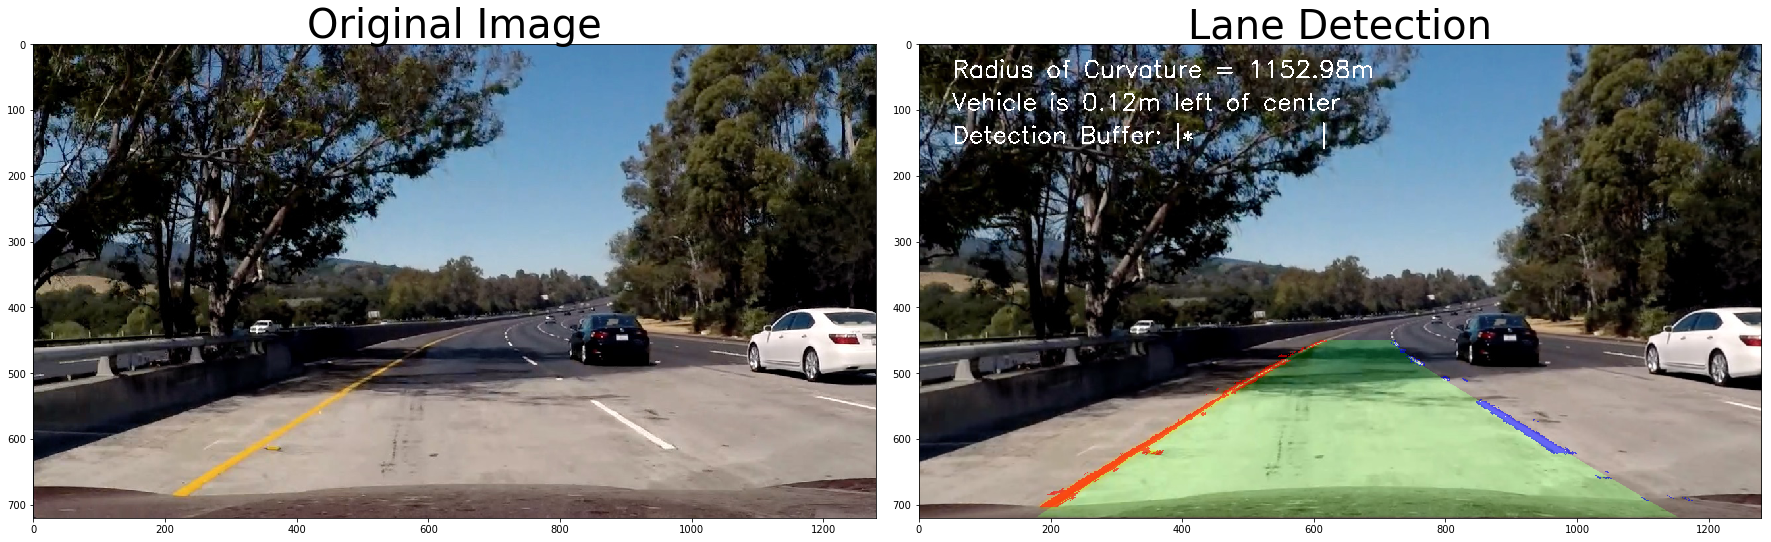

In [6]:
img = mpimg.imread('test_images/test5.jpg')

undist = undistortImage(img, calibration)
birds_eye_img = getBirdsEyeView(undist)
l_line, r_line = detectLaneLines(birds_eye_img)
result = drawFoundLaneOverImage(undist, l_line, r_line)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Lane Detection', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/LaneDetectionSample.png")

# Vehicle Detection and Tracking

Methods to identify regions of an image containing cars

In [7]:
# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    # Using cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Returnig the feature vector
    return features


# Computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Computing the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenating the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returning the individual histograms, bin_centers and feature vector
    return hist_features


# Gets HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Calling with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise calling with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



# Converts an image to the given color space
# Color space can be RGB, HSV, LUV, HLS, YUV, YCrCb
def convert_color(image, cspace='YCrCb'):
    # Applying color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(image)


# Extracts the combined HOG and color features
def extract_features(imgs, cspace='RGB', 
                     spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Creating a list to append feature vectors to
    features = []
    # Iterating through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # Applying color conversion
        feature_image = convert_color(image, cspace=cspace)

        # Applying bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Applying color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Calling get_hog_features() with vis=False, feature_vec=True
        # to get the HOG features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(
                    get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, 
                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        # Appending the new feature vector to the features list
        features.append(np.ravel(np.hstack((spatial_features, hist_features, hog_features))))
    # Returning the list of feature vectors
    return features



# Returns a collection of boxes corresponding to the predictions of cells that contains cars,
# using the Window Sliding approach.
# It extracts HOG features of the whole image then it uses HOG sub-sampling and
# extracting color features from sub-images
def find_cars(img, xstart, xstop, ystart, ystop, scale,
              clf, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):

    img = img.astype(np.float32)/255
    # Sub-images to perform the search on
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    # Transforming image to YCrCb color space
    ctrans_tosearch = convert_color(img_tosearch, cspace='YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Color channels
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Defining blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Computing individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extracting HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extracting the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Getting color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scaling features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)

            # If the image patch is predicated to contain a car, the box is added to the collection to return
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bboxes.append(((xbox_left + xstart, ytop_draw + ystart),
                               (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))

    return bboxes


# Performs the process of cars identification per different scales for the image patches
def find_cars_multi_scale(img, xstart, xstop, ystart, ystop, scales,
                          clf, X_scaler,
                          orient, pix_per_cell, cell_per_block,
                          spatial_size, hist_bins):
    bboxes = []
    for scale in scales:
        bboxes += find_cars(img, xstart, xstop, ystart, ystop, scale,
                            clf, X_scaler,
                            orient, pix_per_cell, cell_per_block,
                            spatial_size, hist_bins)
    return bboxes


# Draws a collection of boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Making a copy of the image
    draw_img = np.copy(img)
    # Drawing each bounding box on the image's copy using cv2.rectangle()
    for bbox in bboxes:
        # Drawing a rectangle given the bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Returning the image's copy with boxes drawn
    return draw_img


# Adds a given heat amount in the heatmap inside the given boxes
def add_heat(heatmap, bboxes, heat_amt=1):
    # Iterating through the list of bboxes
    for box in bboxes:
        # Adding heat_amt for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat_amt
    # Returning the updated heatmap
    return heatmap


# Dilutes the existing heat in a heatmap given a spacific ratio
def dilute_heat(heatmap, dilution_ratio=0.5):
    # Multiplying all the pixels by the given ratio
    heatmap *= dilution_ratio
    return heatmap


# Zeroes the heatmap's pixels under a given threshold
def apply_threshold(heatmap, threshold):
    # Zeroing out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Returning thresholded map
    return heatmap


# Sets the heat in a heatmap, considering the previous status of the heatmat
# the amount of heat to add per box, a given threshold 
# and a dilution ratio applied to the previous status
def set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=2, dilution_ratio=0.5):
    dilute_heat(heatmap, dilution_ratio=0.5)
    add_heat(heatmap, bboxes, heat_amt)
    apply_threshold(heatmap, heat_threshold)
    return heatmap


# Chacks that a detected box containing a car is reliable
def sanity_check_bbox(bbox):
    w = fabs(bbox[1][0] - bbox[0][0])
    h = fabs(bbox[1][1] - bbox[0][1])
    if (w/h < 0.3):
        return False
    if (h/w < 0.3):
        return False    
    return True


# Draws the boxes corresponding to the regions identified in the labels collections
# which come from a heatmap
def draw_labeled_bboxes(img, labels, color=(0,0,255)):
    # Iterating through all detected cars
    for car_number in range(1, labels[1]+1):
        # Finding pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identifying x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Defining a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Drawing the box on the image if passes the sanity check
        if sanity_check_bbox(bbox):
            cv2.rectangle(img, bbox[0], bbox[1], color, 6)
    # Returning the image
    return img

Loading classifier from pickle file

In [8]:
classifier_data = pickle.load(open("best_clf_pickle.p", "rb" ))
clf = classifier_data["clf"]
X_scaler = classifier_data["scaler"]
orient = classifier_data["orient"]
pix_per_cell = classifier_data["pix_per_cell"]
cell_per_block = classifier_data["cell_per_block"]
spatial_size = classifier_data["spatial_size"]
hist_bins = classifier_data["hist_bins"]

xstart = 0
xstop = 1280
ystart = 360
ystop = 720

Testing the mechanims to identify cars togheter with the lanes

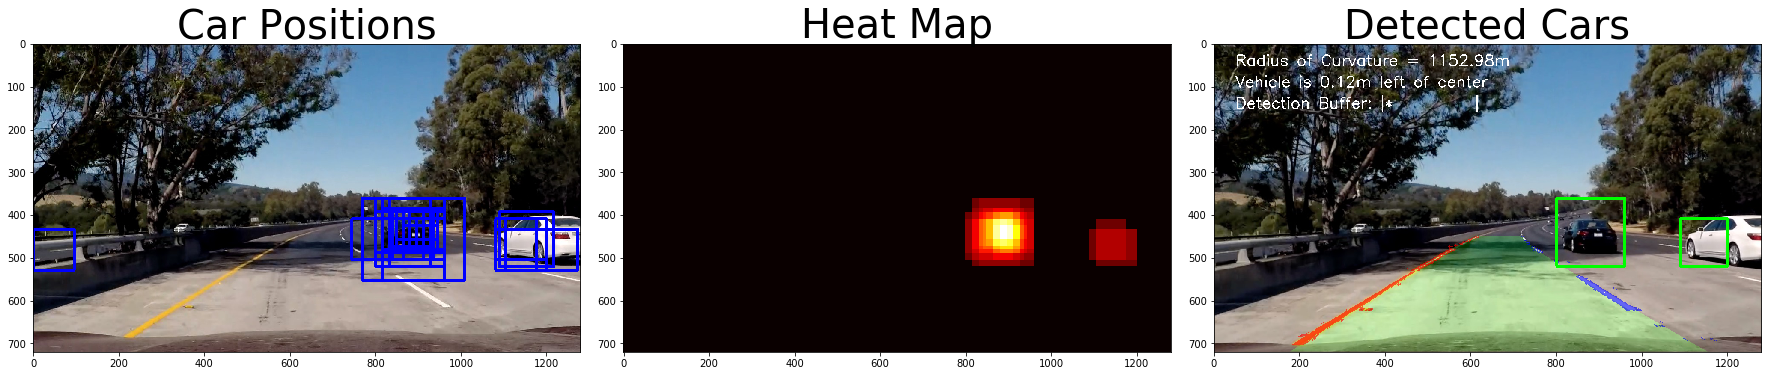

In [9]:
img = mpimg.imread('test_images/test5.jpg')
undist = undistortImage(img, calibration)


bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0],
                               clf, X_scaler,
                               orient, pix_per_cell, cell_per_block,
                               spatial_size, hist_bins)
out_img = draw_boxes(img, bboxes)

# Identifying cars
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=4, dilution_ratio=0.5)
heatmap_img = np.clip(heatmap, 0, 255)
labels = label(heatmap_img)

# Identifying lanes
birds_eye_img = getBirdsEyeView(undist)
l_line, r_line = detectLaneLines(birds_eye_img)

draw_img = draw_labeled_bboxes(drawFoundLaneOverImage(undist, l_line, r_line), labels, color=(0, 255, 0))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Car Positions', fontsize=40)
ax2.imshow(heatmap_img, cmap='hot')
ax2.set_title('Heat Map', fontsize=40)
ax3.imshow(draw_img)
ax3.set_title('Detected Cars', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.0)
plt.savefig("output_images/CarDetectionWithLanesProcess.png")

# Cobining Cars and Lane detection

Pipeline

In [10]:
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
frames_interval = 10 # The detection is going to take place every N frames defined by this value
frame_count = 0
labels = None
buff_l_line = None
buff_r_line = None

# Pipeline to process the serie of images from source video
def process_image(img):
    global heatmap
    global frames_interval
    global frame_count
    global labels
    global buff_l_line
    global buff_r_line

    # Identifying cars
    if frame_count % frames_interval == 0:
        bboxes = find_cars_multi_scale(img, xstart, xstop, ystart, ystop, [1.0, 1.5, 2.0, 3.0],
                                       clf, X_scaler,
                                       orient, pix_per_cell, cell_per_block,
                                       spatial_size, hist_bins)
        set_heat(heatmap, bboxes, heat_amt=2, heat_threshold=6, dilution_ratio=0.5)
        heatmap_img = np.clip(heatmap, 0, 255)
        labels = label(heatmap_img)

    # Identifying lane
    img = undistortImage(img, calibration)
    birds_eye_img = getBirdsEyeView(img)
    buff_l_line, buff_r_line = detectLaneLines(birds_eye_img, prev_l_line=buff_l_line, prev_r_line=buff_r_line)

    frame_count += 1
    return draw_labeled_bboxes(drawFoundLaneOverImage(img, buff_l_line, buff_r_line), labels, color=(0, 255, 0))

Generating video

In [11]:
video_output = 'result-extra.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result-extra.mp4
[MoviePy] Writing video result-extra.mp4


100%|█████████▉| 1260/1261 [11:15<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result-extra.mp4 

CPU times: user 12min 39s, sys: 54.9 s, total: 13min 34s
Wall time: 11min 16s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))